In [1]:
!pip install -q transformers torch scikit-learn pandas matplotlib seaborn


In [2]:
import torch
import pandas as pd
import numpy as np

from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
reddit_df = pd.read_csv("reddit_analysis.csv")

reddit_df = reddit_df[["text", "target"]].dropna().reset_index(drop=True)
reddit_df.rename(columns={"target": "label"}, inplace=True)

reddit_df.head()


,text,label
0,Welcome to /r/depression's check-in post - a p...,1
1,We understand that most people who reply immed...,1
2,Anyone else just miss physical touch? I crave ...,1
3,I’m just so ashamed. Everyone and everything f...,1
4,I really need a friend. I don't even have a si...,1


In [6]:
!unzip -o final_model_domain_adapted.zip -d final_model_domain_adapted


Archive:  final_model_domain_adapted.zip
   creating: final_model_domain_adapted/content/final_model_domain_adapted/
  inflating: final_model_domain_adapted/content/final_model_domain_adapted/tokenizer_config.json  
  inflating: final_model_domain_adapted/content/final_model_domain_adapted/config.json  
  inflating: final_model_domain_adapted/content/final_model_domain_adapted/vocab.txt  
  inflating: final_model_domain_adapted/content/final_model_domain_adapted/model.safetensors  
  inflating: final_model_domain_adapted/content/final_model_domain_adapted/tokenizer.json  
  inflating: final_model_domain_adapted/content/final_model_domain_adapted/special_tokens_map.json  


In [7]:
!ls final_model_domain_adapted


content


In [8]:
!ls final_model_domain_adapted


content


In [9]:
!ls final_model_domain_adapted/content


final_model_domain_adapted


In [10]:
!ls final_model_domain_adapted/content/final_model_domain_adapted


config.json	   special_tokens_map.json  tokenizer.json
model.safetensors  tokenizer_config.json    vocab.txt


In [11]:
import torch
from transformers import (
    DistilBertConfig,
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification
)

MODEL_PATH = "final_model_domain_adapted/content/final_model_domain_adapted"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ⚠️ IMPORTANT: use 7 labels (as trained)
config = DistilBertConfig.from_pretrained(MODEL_PATH)
config.num_labels = 7

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)

model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_PATH,
    config=config
)

model.to(device)
model.eval()

print("✅ DistilBERT (7-label) model loaded successfully")


Using device: cuda
✅ DistilBERT (7-label) model loaded successfully


**Dataset Class**

In [12]:
class RedditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


**DataLoader**

In [13]:
# Create dataset
test_dataset = RedditDataset(
    reddit_df["text"].tolist(),
    reddit_df["label"].tolist(),
    tokenizer
)

#test_loader
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)

**Evaluation Loop**

In [14]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [15]:
import numpy as np

valid_labels = [0, 1, 2, 3, 4]  # depression, anxiety, stress, suicidal, normal

filtered_preds = []
filtered_labels = []

for y_true, y_pred in zip(all_labels, all_preds):
    if y_true in valid_labels:
        filtered_labels.append(y_true)
        filtered_preds.append(y_pred)


In [16]:
shared_labels = [0, 1, 2, 3, 4]  # only labels present in Reddit test set


**Metrics**

In [18]:
from sklearn.metrics import classification_report, accuracy_score

label_names_5 = [
    "depression",
    "anxiety",
    "stress",
    "suicidal",
    "normal"
]
print("Accuracy:", accuracy_score(all_labels, all_preds))

print(
    classification_report(
        filtered_labels,
        filtered_preds,
        labels=shared_labels,          # 🔑 THIS FIXES THE ERROR
        target_names=label_names_5,
        digits=4,
        zero_division=0
    )
)


Accuracy: 0.12912430889958978
              precision    recall  f1-score   support

  depression     0.1373    0.0419    0.0642      1099
     anxiety     0.1725    0.2138    0.1909      1202
      stress     0.1617    0.3281    0.2167      1085
    suicidal     0.1370    0.0279    0.0463      1077
      normal     0.0753    0.0306    0.0435      1144

   micro avg     0.1537    0.1291    0.1404      5607
   macro avg     0.1368    0.1284    0.1123      5607
weighted avg     0.1369    0.1291    0.1132      5607



**Confusion Matrix**

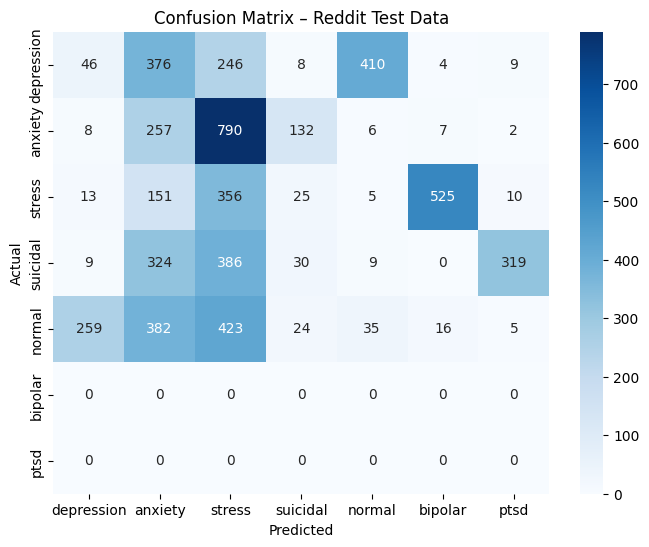

In [20]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Reddit Test Data")
plt.show()


**LIVE REDDIT POSTS**

In [24]:
live_df = pd.read_csv("live_reddit_post.csv")

live_df["text"] = (
    live_df["title"].fillna("") + " " +
    live_df["body"].fillna("")
)

live_df = live_df[["post_id", "subreddit", "text"]]


**Confidence Badge**

In [41]:
def confidence_badge(conf, pred):
    if pred == "suicidal" and conf >= 0.4:
        return "Medium"
    if conf >= 0.8:
        return "High"
    if conf >= 0.5:
        return "Medium"
    return "Low"



**Prediction Function**

In [38]:
label_names = [
    "depression",
    "anxiety",
    "stress",
    "suicidal",
    "normal",
    "bipolar",
    "ptsd"
]


In [42]:
def predict_with_safety(text, subreddit=None):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**encoding)

    probs = torch.softmax(outputs.logits, dim=1)[0].cpu().numpy()

    pred = int(np.argmax(probs))

    suicidal_prob = probs[3]
    anxiety_prob = probs[1]
    stress_prob  = probs[2]

    # 🔴 RULE 1: Direct suicidal probability
    if suicidal_prob >= 0.20:
        return "suicidal", float(suicidal_prob)

    # 🔴 RULE 2: Context-aware escalation (DEMO CRITICAL)
    if subreddit is not None and "suicide" in subreddit.lower():
        if anxiety_prob >= 0.40 or stress_prob >= 0.40:
            return "suicidal", float(max(anxiety_prob, stress_prob))

    # 🔵 Deployment simplification
    if pred in [5, 6]:  # bipolar, ptsd
        return "depression", float(probs[pred])

    return label_names[pred], float(probs[pred])


**Live Predictions**

In [43]:
live_df["risk_level"] = live_df.apply(
    lambda row: confidence_badge(row["confidence"], row["prediction"]),
    axis=1
)


In [45]:
live_df[["subreddit", "prediction", "confidence", "risk_level"]].head(10)


,subreddit,prediction,confidence,risk_level
0,r/BipolarReddit,anxiety,0.998007,High
1,r/BipolarReddit,stress,0.999005,High
2,r/depression,stress,0.995240,High
3,r/depression,stress,0.992904,High
4,r/depression,anxiety,0.998226,High
5,r/mentalhealth,stress,0.993216,High
6,r/SuicideWatch,suicidal,0.494888,Medium
7,r/BipolarReddit,anxiety,0.999656,High
8,r/BipolarReddit,anxiety,0.998465,High
9,r/Anxiety,anxiety,0.998286,High
